# PROJECT WEEK 8 - FAKE & REAL NEWS

#### LIBRARIES

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import re
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering

import nltk
from nltk.corpus import stopwords

%matplotlib inline
sns.set()

#### DATAFRAME

In [10]:
os.chdir('/Users/lucilleartigaud/Ironhack/Cours/806_Repo/Projects/PROJECT8')

In [11]:
fake = pd.read_csv('Fake.csv')
true = pd.read_csv('True.csv')

##### Column True/False

In [12]:
fake['T/F']=0
true['T/F']=1

##### Into 1 single df

In [52]:
news=pd.concat([true, fake]).reset_index(drop=True)
print(f' The 2 datasets had been well merged : {true.shape[0]+fake.shape[0]==news.shape[0]} and the shape of the new dataset is {news.shape}.')

 The 2 datasets had been well merged : True and the shape of the new dataset is (44898, 5).


## FIRST CLEANING

##### Get rid of the duplicated row

In [53]:
# 209 duplicated rows : 
news[news.duplicated()]

,title,text,subject,date,T/F
445,Senate tax bill stalls on deficit-focused 'tri...,WASHINGTON (Reuters) - The U.S. Senate on Thur...,politicsNews,"November 30, 2017",1
778,Trump warns 'rogue regime' North Korea of grav...,BEIJING (Reuters) - U.S. President Donald Trum...,politicsNews,"November 8, 2017",1
892,"Republicans unveil tax cut bill, but the hard ...",WASHINGTON (Reuters) - U.S. House of Represent...,politicsNews,"November 2, 2017",1
896,Trump taps Fed centrist Powell to lead U.S. ce...,WASHINGTON (Reuters) - President Donald Trump ...,politicsNews,"November 2, 2017",1
974,"Two ex-Trump aides charged in Russia probe, th...",WASHINGTON (Reuters) - Federal investigators p...,politicsNews,"October 30, 2017",1
...,...,...,...,...,...
21353,Thailand's ousted PM Yingluck has fled abroad:...,BANGKOK (Reuters) - Ousted Thai prime minister...,worldnews,"August 25, 2017",1
21408,"U.S., North Korea clash at U.N. forum over nuc...",GENEVA (Reuters) - North Korea and the United ...,worldnews,"August 22, 2017",1
31359,HILLARY TWEETS MESSAGE In Defense Of DACA…OOPS...,No time to waste we've got to fight with eve...,politics,"Sep 9, 2017",0
32863,FORMER DEMOCRAT WARNS Young Americans: “Rioter...,"Who is silencing political speech, physically...",politics,"Mar 10, 2017",0


In [54]:
# Juste pour vérifier que si on supprime les 209 duplicated rows, notre nb de rows sera : 44898-209 : 
news.drop_duplicates(keep='last').shape[0]==news.shape[0]-209

True

In [55]:
news=news.drop_duplicates(keep='last')

##### Date to datetime

In [57]:
#FIRST : REPLACE STRING BY NUMBER OF MONTH

news.loc[news.date.str.contains('December'), 'date']=news.date.str.replace('December', '12, ')
news.loc[news.date.str.contains('January'), 'date']=news.date.str.replace('January', '01, ')
news.loc[news.date.str.contains('February'), 'date']=news.date.str.replace('February', '02, ')
news.loc[news.date.str.contains('March'), 'date']=news.date.str.replace('March', '03, ')
news.loc[news.date.str.contains('April'), 'date']=news.date.str.replace('April', '04, ')
news.loc[news.date.str.contains('May'), 'date']=news.date.str.replace('May', '05, ')
news.loc[news.date.str.contains('June'), 'date']=news.date.str.replace('June', '06, ')
news.loc[news.date.str.contains('July'), 'date']=news.date.str.replace('July', '07, ')
news.loc[news.date.str.contains('August'), 'date']=news.date.str.replace('August', '08, ')
news.loc[news.date.str.contains('September'), 'date']=news.date.str.replace('September', '09, ')
news.loc[news.date.str.contains('October'), 'date']=news.date.str.replace('October', '10, ')
news.loc[news.date.str.contains('November'), 'date']=news.date.str.replace('November', '11, ')

news.loc[news.date.str.contains(', '), 'date']=news.date.str.replace(', ', '-')

news.date

0        12- 31-2017 
1        12- 29-2017 
2        12- 31-2017 
3        12- 30-2017 
4        12- 29-2017 
             ...     
44893     01- 16-2016
44894     01- 16-2016
44895     01- 15-2016
44896     01- 14-2016
44897     01- 12-2016
Name: date, Length: 44689, dtype: object

In [58]:
# THEN HANDLE THE WEIRD VALUES :

# 1. Some dates can be found and corrected : 

news.loc[news.date=='https://100percentfedup.com/served-roy-moore-vietnamletter-veteran-sets-record-straight-honorable-decent-respectable-patriotic-commander-soldier/', 'date']='12-25-2017'
news.loc[news.date=='https://100percentfedup.com/video-hillary-asked-about-trump-i-just-want-to-eat-some-pie/', 'date']='07-05-2015'
news.loc[news.date=='https://100percentfedup.com/video-hillary-asked-about-trump-i-just-want-to-eat-some-pie/', 'date']='07-05-2015'
news.loc[news.date=='https://100percentfedup.com/12-yr-old-black-conservative-whose-video-to-obama-went-viral-do-you-really-love-america-receives-death-threats-from-left/', 'date']='07-04-2015'

# 2. Some rows has to be deleted because they have no relevant info : 

news = news.drop([37256, 38849, 43286])
news=news.drop([37257, 38850, 43287])
news=news.drop(40350)

# 3. To datetime : 

news.date = pd.to_datetime(news.date)
news.reset_index(drop=True, inplace=True)

##### Add a column to count the nb of caracters in the title

In [59]:
news['nb_car_title']=[len(i) for i in news['title']]

##### Add a column to count the nb of caracters in the text of the article

In [60]:
news['nb_car_text']=[len(i) for i in news['text']]

##### Add a column that counts the articles with an image

In [61]:
news['is_image'] = np.where(news.text.str.contains('bit.ly')==True, 1, 0)
news.loc[news['text'].str.contains('Photo by'), 'is_image']=1
news.loc[news['text'].str.contains('photo credit'), 'is_image']=1
news.loc[news['text'].str.contains('Photo credit'), 'is_image']=1
news.loc[news['text'].str.contains('.jpg'), 'is_image']=1
news.loc[news['text'].str.contains('.png'), 'is_image']=1

##### Add a column source

In [62]:
news['source']=''
news['source'].loc[news['text'].str.lower().str.contains('reuters')]='Reuters'
news.loc[news['text'].str.lower().str.contains('reuters')]
news.source.loc[(news.source!='Reuters')&(news.text.str.lower().str.contains('twitter'))]='Twitter'
news.source.loc[(news.source!='Reuters')&(news.source!='Twitter')&(news.text.str.lower().str.contains('cnn'))]='CNN'
news.source.loc[(news.source!='Reuters')&(news.source!='Twitter')&(news.source!='CNN')]='Other'

/Users/lucilleartigaud/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


##### Add a column countries

In [63]:
from geotext import GeoText

news=news.assign(countries=np.nan)

In [64]:
for i in range(news.shape[0]):
    news['countries'][i]=GeoText(str(news['text'][i])).countries

/Users/lucilleartigaud/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


##### Extract the links

In [65]:
news['urls']=''
for i in range(news.shape[0]):
    news['urls'][i] = re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', str(news['text'][i]))

news['text']=news['text'].str.replace('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', case=False)

/Users/lucilleartigaud/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


###### Add columns counting special caracters in title & text

In [66]:
news['nb_spec_car_text']=[re.subn(r"[^\ \w]", '', i)[1] for i in news.text]
news['nb_spec_car_title']=[re.subn(r"[^\ \w]", '', i)[1] for i in news.title]

##### Token / Stemming

In [67]:
#TEXT

#Drop special caracters
news['textclean']= news['text'].str.replace('[^\w\s]','')

#remove html tags
news['textclean'] = news['textclean'].str.replace('<.*?>', '', case=False)

#lowercase
news['textclean']=news['textclean'].str.lower()

news['textclean']=news['textclean'].apply(lambda x: ' '.join([word for word in x.split()]))

In [68]:
#tokenize
from nltk.tokenize import word_tokenize

tokens = news['textclean'].apply(word_tokenize)

In [69]:
# stemming of words
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()

stemmed = [porter.stem(str(x)) for x in tokens]

In [70]:
bow={j for i in tokens.to_list() for j in i}
stem_map={i: porter.stem(i) for i in bow}
tokens1=tokens.map(lambda x: [stem_map[j] for j in x])

In [71]:
# x y split from tokens1

In [72]:
tokens1=tokens1.apply(lambda x: ' '.join(x))

In [35]:
news['stemtokens']=tokens1

## TRAIN / TEST SPLIT

In [36]:
from sklearn.model_selection import train_test_split

In [37]:
X_train, X_test, y_train, y_test = train_test_split(news, \
                                                    news['T/F'], \
                                                  test_size=1/3, \
                                                  random_state=42)

In [191]:
X_train

##### Tf Idf

In [38]:
vector=TfidfVectorizer(max_df=0.5, max_features=1000, stop_words='english')

In [39]:
vectorized = vector.fit_transform(X_train.stemtokens)

##### Creation of clusters

In [40]:
km=KMeans(n_clusters=10, verbose=2) #verbose=2 prints all the steps

In [41]:
km.fit(vectorized)

Initialization complete
Iteration  0, inertia 29256.082
Iteration  1, inertia 26986.009
Iteration  2, inertia 26715.481
Iteration  3, inertia 26616.539
Iteration  4, inertia 26575.849
Iteration  5, inertia 26532.946
Iteration  6, inertia 26452.511
Iteration  7, inertia 26337.776
Iteration  8, inertia 26142.561
Iteration  9, inertia 26029.638
Iteration 10, inertia 25998.669
Iteration 11, inertia 25983.730
Iteration 12, inertia 25972.718
Iteration 13, inertia 25966.790
Iteration 14, inertia 25963.591
Iteration 15, inertia 25961.150
Iteration 16, inertia 25959.061
Iteration 17, inertia 25955.963
Iteration 18, inertia 25951.986
Iteration 19, inertia 25947.833
Iteration 20, inertia 25941.294
Iteration 21, inertia 25935.026
Iteration 22, inertia 25930.576
Iteration 23, inertia 25927.967
Iteration 24, inertia 25927.012
Iteration 25, inertia 25926.719
Iteration 26, inertia 25926.587
Iteration 27, inertia 25926.520
Iteration 28, inertia 25926.486
Iteration 29, inertia 25926.470
Iteration 30, in

Iteration 58, inertia 25907.567
Iteration 59, inertia 25905.946
Iteration 60, inertia 25904.525
Iteration 61, inertia 25902.682
Iteration 62, inertia 25900.454
Iteration 63, inertia 25897.082
Iteration 64, inertia 25889.291
Iteration 65, inertia 25872.442
Iteration 66, inertia 25859.982
Iteration 67, inertia 25858.107
Iteration 68, inertia 25857.095
Iteration 69, inertia 25856.252
Iteration 70, inertia 25855.488
Iteration 71, inertia 25855.150
Iteration 72, inertia 25854.945
Iteration 73, inertia 25854.854
Iteration 74, inertia 25854.809
Iteration 75, inertia 25854.772
Iteration 76, inertia 25854.744
Iteration 77, inertia 25854.722
Iteration 78, inertia 25854.702
Iteration 79, inertia 25854.694
Iteration 80, inertia 25854.689
Iteration 81, inertia 25854.686
Iteration 82, inertia 25854.684
Iteration 83, inertia 25854.683
Iteration 84, inertia 25854.682
Iteration 85, inertia 25854.681
Converged at iteration 85: center shift 0.000000e+00 within tolerance 9.128259e-08
Initialization comple

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=2)

<BarContainer object of 10 artists>

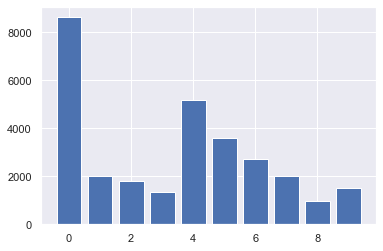

In [42]:
# Ploting the nomber of rows for each cluster

a, b=np.unique(km.labels_, return_counts=True)
np.unique(km.labels_, return_counts=True)
km.labels_
plt.bar(a,b)

In [156]:
terms=vector.get_feature_names()
for i in range(10):
    print(f'Cluster {i+1}:')
    for ind in km.cluster_centers_.argsort()[:,::-1][i,:10]:
        print(terms[ind],end=' ')
    print()

Cluster 1:
peopl obama like just trump state say american year time 
Cluster 2:
parti eu minist govern european prime elect parliament britain reuter 
Cluster 3:
russian russia trump investig moscow intellig putin comey elect fbi 
Cluster 4:
court suprem judg rule justic law case state appeal order 
Cluster 5:
trump donald republican imag campaign white peopl like just support 
Cluster 6:
state iran unit militari reuter syria govern forc islam saudi 
Cluster 7:
senat tax republican hous trump democrat legisl vote congress washington 
Cluster 8:
clinton hillari trump email democrat campaign sander state presidenti elect 
Cluster 9:
korea north china korean nuclear missil south beij trump chines 
Cluster 10:
polic offic arrest protest kill black attack peopl shoot man 


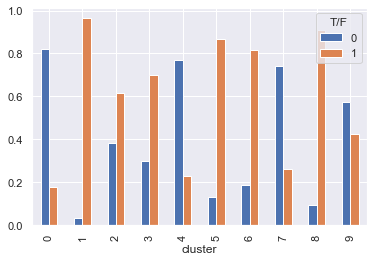

In [195]:
X_train['cluster']=km.labels_

# PLOT CROSSTAB SAMPLE TEST CLUSTERS

tab = pd.crosstab(X_train.cluster, y_train, normalize='index', margins=True)

fig, ax = plt.subplots()
pd.crosstab(X_train.cluster, y_train, normalize='index', margins=True).iloc[:-1].plot(ax=ax, kind='bar')


plt.show()

In [196]:
X_train.head()

,T/F,nb_car_title,nb_car_text,is_image,nb_spec_car_text,nb_spec_car_title,nb_url,subject_Middle-east,subject_News,subject_US_News,...,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster
43640,0,64,1882,0,33,4,0,0,0,1,...,0,0,0,0,1,0,0,0,0,5
11791,1,75,2675,0,73,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,8
9702,1,53,2182,0,56,2,0,0,0,0,...,0,0,0,0,0,0,0,1,0,8
23323,0,91,2558,1,59,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,8
13032,1,82,739,0,11,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1


## SECOND CLEANING FOR THE MODELLING

##### Get dummies

In [75]:
X_train['nb_url']=[len(i) for i in X_train['urls']]
X_train.loc[X_train.nb_url>2, 'nb_url'] = 3
X_train.nb_url=X_train.nb_url.astype(int)

dummies = ['subject', 'source', 'cluster']
X_train=pd.get_dummies(data=X_train, columns=dummies, drop_first=True)

/Users/lucilleartigaud/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/lucilleartigaud/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/lucilleartigaud/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

In [81]:
X_train

,T/F,nb_car_title,nb_car_text,is_image,nb_spec_car_text,nb_spec_car_title,stemtokens,nb_url,subject_Middle-east,subject_News,...,source_Twitter,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9
43640,0,64,1882,0,33,4,21st centuri wire say it seem that us antiruss...,0,0,0,...,0,0,0,0,0,1,0,0,0,0
11791,1,75,2675,0,73,1,tokyo reuter japan formal decid on tuesday it ...,0,0,0,...,0,0,0,0,0,0,0,0,1,0
9702,1,53,2182,0,56,2,washington reuter the unit state said thursday...,0,0,0,...,0,0,0,0,0,0,0,0,1,0
23323,0,91,2558,1,59,1,while trump s secretari of state wa visit a un...,0,0,1,...,0,0,0,0,0,0,0,0,1,0
13032,1,82,739,0,11,1,belfast reuter the leader of the northern iris...,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,1,55,1231,0,42,2,berlin reuter german financ minist wolfgang sc...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11284,1,54,1871,0,39,2,puerto ordaz venezuela reuter venezuelan autho...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38158,0,88,920,0,15,2,thi is some pretti surreal stuff in the four y...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
860,1,64,2971,0,85,0,reuter some wealthi owner of us majorleagu spo...,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [82]:
X_train = X_train.drop('stemtokens', axis=1)

##### Only numeric values

In [182]:
X_train = X_train.drop(['title', 'text', 'date', 'countries', 'urls', 'textclean', 'stemtokens'], axis=1)

###### Proper types

In [ ]:
integer=['T/F', 'nb_car_title', 'nb_car_text', 'is_image', 'nb_spec_car_text', 'nb_spec_car_title']
X_train[integer]=X_train[integer].astype(int)

In [84]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29788 entries, 43640 to 15795
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   T/F                   29788 non-null  int64
 1   nb_car_title          29788 non-null  int64
 2   nb_car_text           29788 non-null  int64
 3   is_image              29788 non-null  int64
 4   nb_spec_car_text      29788 non-null  int64
 5   nb_spec_car_title     29788 non-null  int64
 6   nb_url                29788 non-null  int64
 7   subject_Middle-east   29788 non-null  uint8
 8   subject_News          29788 non-null  uint8
 9   subject_US_News       29788 non-null  uint8
 10  subject_left-news     29788 non-null  uint8
 11  subject_politics      29788 non-null  uint8
 12  subject_politicsNews  29788 non-null  uint8
 13  subject_worldnews     29788 non-null  uint8
 14  source_Other          29788 non-null  uint8
 15  source_Reuters        29788 non-null  uint8
 16  

In [85]:
X_train.sample(10)

,T/F,nb_car_title,nb_car_text,is_image,nb_spec_car_text,nb_spec_car_title,nb_url,subject_Middle-east,subject_News,subject_US_News,...,source_Twitter,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9
36829,0,62,3299,0,72,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
42266,0,89,192,0,2,7,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24855,0,79,2362,0,58,4,0,0,1,0,...,1,0,0,0,1,0,0,0,0,0
21539,0,96,2551,0,70,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
42298,0,152,2353,0,112,4,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1312,1,68,2198,0,65,2,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
29137,0,93,1946,0,39,1,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
33358,0,81,179,0,9,2,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
10613,1,70,504,0,11,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
15465,1,69,1089,0,22,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## Visualization

##### Origins of the subjects

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot("subject", data=X_train)
plt.show()

##### Balanced data

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot("T/F", data=X_train)
plt.show()

##### Word Cloud

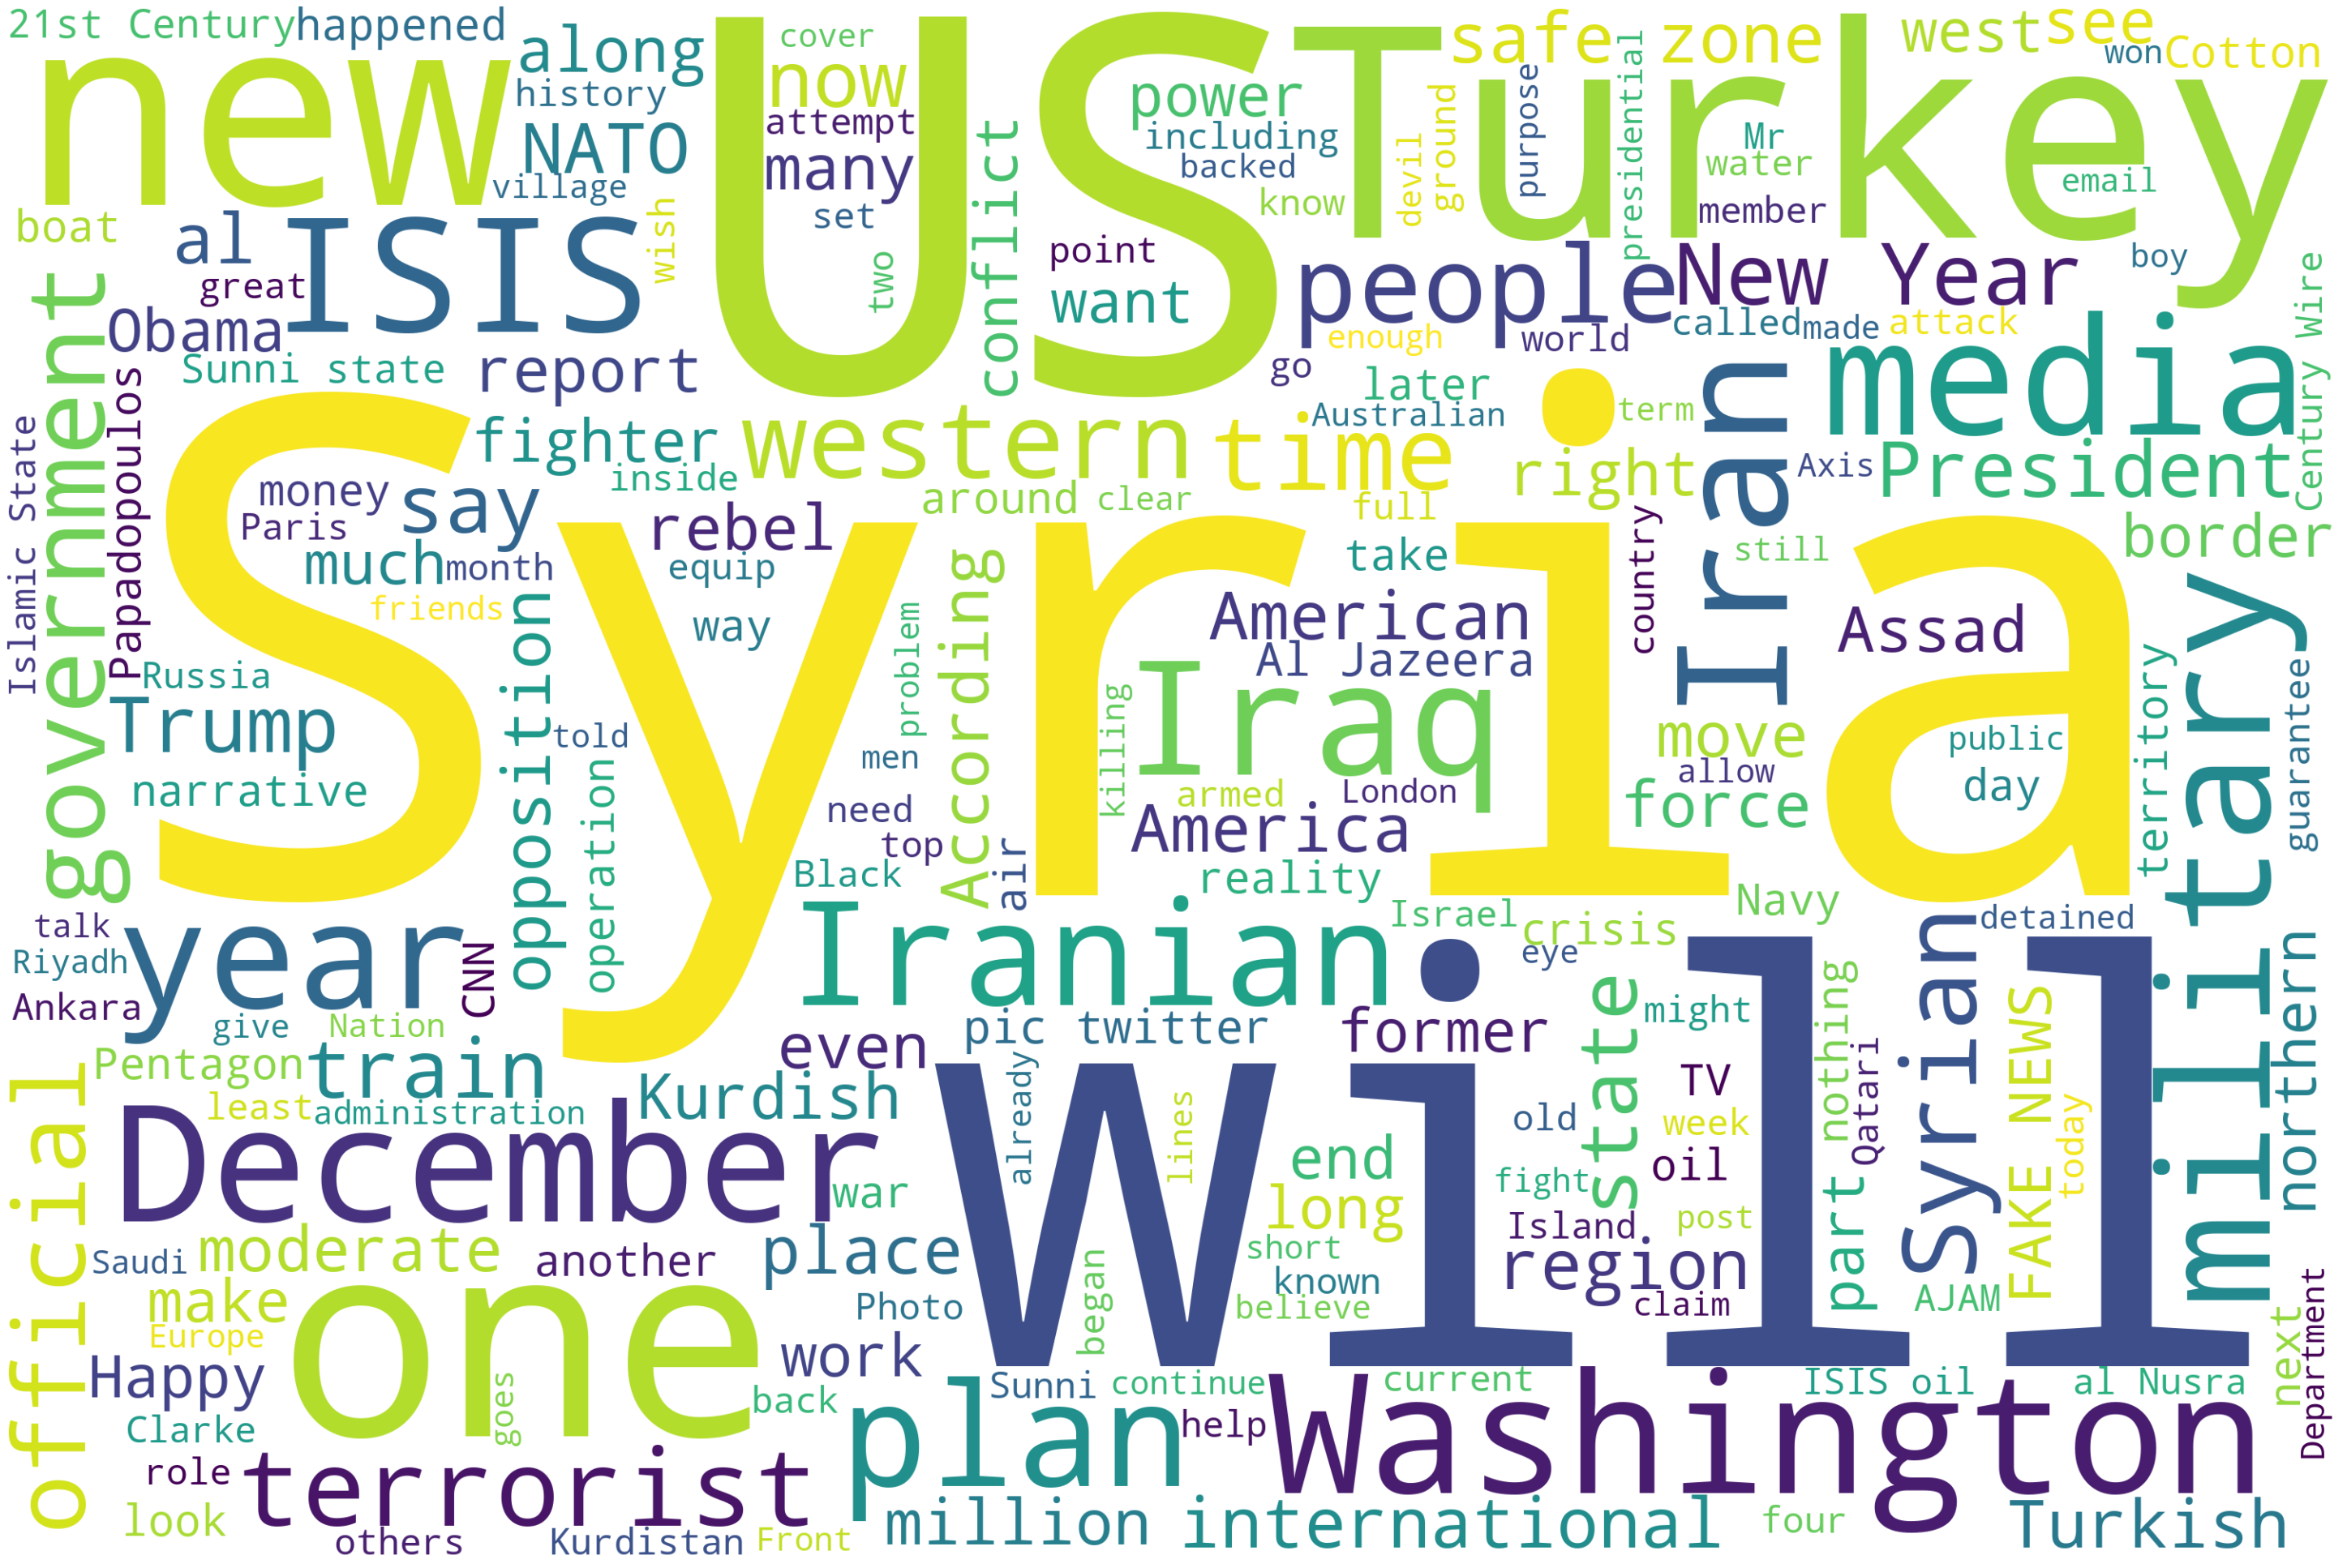

In [188]:
# TRUE NEWS

words_true = news['text'].loc[news['T/F']==0].values
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white',
    stopwords = STOPWORDS).generate(str(words_true))
fig = plt.figure(
    figsize = (40, 30))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [201]:
# FAKE NEWS

words_fake = news['text'].loc[news['T/F']==1].values
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white',
    ordered.colors=TRUE,
    stopwords = STOPWORDS).generate(str(words_fake))
    
fig = plt.figure(
    figsize = (40, 30))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

SyntaxError: keyword can't be an expression (<ipython-input-201-6d05f766869d>, line 8)

##### Wordcloud for every cluster

In [193]:
X_train_viz

,T/F,nb_car_title,nb_car_text,is_image,nb_spec_car_text,nb_spec_car_title,nb_url,subject_Middle-east,subject_News,subject_US_News,...,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster
43640,0,64,1882,0,33,4,0,0,0,1,...,0,0,0,0,1,0,0,0,0,5
11791,1,75,2675,0,73,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,8
9702,1,53,2182,0,56,2,0,0,0,0,...,0,0,0,0,0,0,0,1,0,8
23323,0,91,2558,1,59,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,8
13032,1,82,739,0,11,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,1,55,1231,0,42,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11284,1,54,1871,0,39,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38158,0,88,920,0,15,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
860,1,64,2971,0,85,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,6


In [ ]:
words = X_train['text'].values
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white',
    stopwords = STOPWORDS).generate(str(words))
fig = plt.figure(
    figsize = (40, 30))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()



wordcloud(words = df$name, freq = df$freq, min.freq = 1,scale = c(2, 0.2),
                    max.words=200, random.order=FALSE, rot.per=0.1, 
                    ordered.colors=TRUE,
                     colors=brewer.pal(8, "Dark2")[factor(df$year)])

## SECOND SPLIT : TEST SPLIT

In [86]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, \
                                                y_train, \
                                                  test_size=1/3, \
                                                  random_state=42)

## Modeling

In [88]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.svm import NuSVC
from sklearn.ensemble import AdaBoostClassifier

#from xgboost import XGBClassifier
#from catboost import CatBoostClassifier

from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import auc, roc_auc_score, roc_curve

##### KNeighbors

In [89]:
"""from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold

params={'n_neighbors':range(3,10,2), #4
'weights':['uniform','distance'], #2
'leaf_size':[30,45], #2
'p':[2,3]} #2

model=KNeighborsClassifier(n_jobs=-1)

cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

grid_search=GridSearchCV(estimator=model, param_grid=params, n_jobs=-1, scoring='recall', cv=cv)

grid_results=grid_search.fit(X_train,y_train)

print('Best model has',grid_result.best_score_, 'recall using',grid_result.best_params_, confusion_matrix(y_test,grid_results.predict(X_test)))"""

NameError: name 'grid_result' is not defined

##### Logistic Regression

In [90]:
model1=LogisticRegression(max_iter=1e8)
model1.fit(X_tr,y_tr)
y_pred1=model1.predict(X_val) # val
conf1=confusion_matrix(y_val,y_pred1)
display(conf1)
acc1=accuracy_score(y_val,y_pred1)
rec1=recall_score(y_val,y_pred1)
pr1=precision_score(y_val,y_pred1)
f11=f1_score(y_val,y_pred1)
print(acc1,pr1,rec1,f11)

array([[5249,    0],
       [   0, 4681]])

1.0 1.0 1.0 1.0


#####  Logistic Regression balanced

In [91]:
model2=LogisticRegression(max_iter=1e8, class_weight='balanced')
model2.fit(X_tr,y_tr)
y_pred2=model2.predict(X_val)
conf2=confusion_matrix(y_val,y_pred2)
display(conf2)
acc2=accuracy_score(y_val,y_pred2)
rec2=recall_score(y_val,y_pred2)
pr2=precision_score(y_val,y_pred2)
f12=f1_score(y_val,y_pred2)
print(acc2,pr2,rec2,f12)

array([[5249,    0],
       [   0, 4681]])

1.0 1.0 1.0 1.0


##### Nu-Support Vector Machine

In [92]:
model4=NuSVC(nu=0.1)
model4.fit(X_tr,y_tr)
y_pred4=model4.predict(X_val)
conf4=confusion_matrix(y_val,y_pred4)
display(conf4)
acc4=accuracy_score(y_val,y_pred4)
rec4=recall_score(y_val,y_pred4)
pr4=precision_score(y_val,y_pred4)
f14=f1_score(y_val,y_pred4)
print(acc4,pr4,rec4,f14)

array([[4770,  479],
       [ 617, 4064]])

0.8896273917421954 0.8945630640545895 0.8681905575731681 0.8811795316565482


##### Gaussian Naive Bayes

In [93]:
model5=GaussianNB()
model5.fit(X_tr,y_tr)
y_pred5=model5.predict(X_val)
conf5=confusion_matrix(y_val,y_pred5)
display(conf5)
acc5=accuracy_score(y_val,y_pred5)
rec5=recall_score(y_val,y_pred5)
pr5=precision_score(y_val,y_pred5)
f15=f1_score(y_val,y_pred5)
print(acc5,pr5,rec5,f15)

array([[5249,    0],
       [   0, 4681]])

1.0 1.0 1.0 1.0


###### Decision Trees

In [94]:
model6=DecisionTreeClassifier()
model6.fit(X_tr,y_tr)
y_pred6=model6.predict(X_val)
conf6=confusion_matrix(y_val,y_pred6)
display(conf6)
acc6=accuracy_score(y_val,y_pred6)
rec6=recall_score(y_val,y_pred6)
pr6=precision_score(y_val,y_pred6)
f16=f1_score(y_val,y_pred6)
print(acc6,pr6,rec6,f16)

array([[5249,    0],
       [   0, 4681]])

1.0 1.0 1.0 1.0


##### Random Forest

In [95]:
model7=RandomForestClassifier()
model7.fit(X_tr,y_tr)
y_pred7=model7.predict(X_val)
conf7=confusion_matrix(y_val,y_pred7)
display(conf7)
acc7=accuracy_score(y_val,y_pred7)
rec7=recall_score(y_val,y_pred7)
pr7=precision_score(y_val,y_pred7)
f17=f1_score(y_val,y_pred7)
print(acc7,pr7,rec7,f17)

array([[5249,    0],
       [   0, 4681]])

1.0 1.0 1.0 1.0


##### Random Forest balanced

In [96]:
model8=RandomForestClassifier(class_weight='balanced')
model8.fit(X_tr,y_tr)
y_pred8=model8.predict(X_val)
conf8=confusion_matrix(y_val,y_pred8)
display(conf8)
acc8=accuracy_score(y_val,y_pred8)
rec8=recall_score(y_val,y_pred8)
pr8=precision_score(y_val,y_pred8)
f18=f1_score(y_val,y_pred8)
print(acc8,pr8,rec8,f18)

array([[5249,    0],
       [   0, 4681]])

1.0 1.0 1.0 1.0


##### AdaBoost

In [97]:
model9=AdaBoostClassifier()
model9.fit(X_tr,y_tr)
y_pred9=model9.predict(X_val)
conf9=confusion_matrix(y_val,y_pred9)
display(conf9)
acc9=accuracy_score(y_val,y_pred9)
rec9=recall_score(y_val,y_pred9)
pr9=precision_score(y_val,y_pred9)
f19=f1_score(y_val,y_pred9)
print(acc9,pr9,rec9,f19)

array([[5249,    0],
       [   0, 4681]])

1.0 1.0 1.0 1.0


##### XGBoost

In [98]:
"""model10=XGBClassifier()
model10.fit(X_tr,y_tr)
y_pred10=model10.predict(X_val)
conf10=confusion_matrix(y_val,y_pred10)
display(conf10)
acc10=accuracy_score(y_val,y_pred10)
rec10=recall_score(y_val,y_pred10)
pr10=precision_score(y_val,y_pred10)
f110=f1_score(y_val,y_pred10)
print(acc10,pr10,rec10,f110)"""

'model10=XGBClassifier()\nmodel10.fit(X_tr,y_tr)\ny_pred10=model10.predict(X_val)\nconf10=confusion_matrix(y_val,y_pred10)\ndisplay(conf10)\nacc10=accuracy_score(y_val,y_pred10)\nrec10=recall_score(y_val,y_pred10)\npr10=precision_score(y_val,y_pred10)\nf110=f1_score(y_val,y_pred10)\nprint(acc10,pr10,rec10,f110)'

##### K-Nearest Neighbors

In [99]:
model11=KNeighborsClassifier(n_neighbors=3)
model11.fit(X_tr,y_tr)
y_pred11=model11.predict(X_val)
conf11=confusion_matrix(y_val,y_pred11)
display(conf11)
acc11=accuracy_score(y_val,y_pred11)
rec11=recall_score(y_val,y_pred11)
pr11=precision_score(y_val,y_pred11)
f111=f1_score(y_val,y_pred11)
print(acc11,pr11,rec11,f111)

array([[4309,  940],
       [ 647, 4034]])

0.8401812688821753 0.8110172899075191 0.8617816705832088 0.8356292076644225


##### Catboost

In [ ]:
"""
model12=CatBoostClassifier()
model12.fit(X_tr,y_tr)
y_pred12=model12.predict(X_val)
conf12=confusion_matrix(y_test,[eval(i) for i in y_pred12])
display(conf12)
acc12=accuracy_score(y_test,[eval(i) for i in y_pred12])
rec12=recall_score(y_test,[eval(i) for i in y_pred12])
pr12=precision_score(y_test,[eval(i) for i in y_pred12])
f112=f1_score(y_test,[eval(i) for i in y_pred12])
print(acc12,pr12,rec12,f112)"""

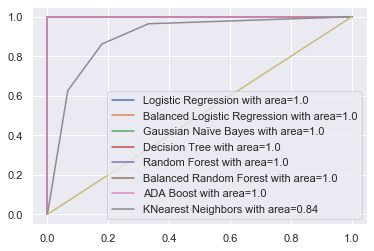

In [102]:
# SELON MEILLEURS

model_roc1=roc_auc_score(y_val, y_pred1)
fpr1,tpr1,thresholds1=roc_curve(y_val, model1.predict_proba(X_val)[:,1])

model_roc2=roc_auc_score(y_val, y_pred2)
fpr2,tpr2,thresholds2=roc_curve(y_val, model2.predict_proba(X_val)[:,1])

#model_roc4=roc_auc_score(y_val, y_pred4)
#fpr4,tpr4,thresholds4=roc_curve(y_val, model4.predict_proba(X_val)[:,1])

model_roc5=roc_auc_score(y_val, y_pred5)
fpr5,tpr5,thresholds5=roc_curve(y_val, model5.predict_proba(X_val)[:,1])

model_roc6=roc_auc_score(y_val, y_pred6)
fpr6,tpr6,thresholds6=roc_curve(y_val, model6.predict_proba(X_val)[:,1])

model_roc7=roc_auc_score(y_val, y_pred7)
fpr7,tpr7,thresholds7=roc_curve(y_val, model7.predict_proba(X_val)[:,1])

model_roc8=roc_auc_score(y_val, y_pred8)
fpr8,tpr8,thresholds8=roc_curve(y_val, model8.predict_proba(X_val)[:,1])

model_roc9=roc_auc_score(y_val, y_pred9)
fpr9,tpr9,thresholds9=roc_curve(y_val, model9.predict_proba(X_val)[:,1])

model_roc11=roc_auc_score(y_val, y_pred11)
fpr11,tpr11,thresholds11=roc_curve(y_val, model11.predict_proba(X_val)[:,1])

plt.figure()
plt.plot(fpr1,tpr1, label=f'Logistic Regression with area={model_roc1.round(2)}')
plt.plot(fpr2,tpr2, label=f'Balanced Logistic Regression with area={model_roc2.round(2)}')
#plt.plot(fpr4,tpr4, label=f'SVM with area={model_roc4.round(2)}')
plt.plot(fpr5,tpr5, label=f'Gaussian Naïve Bayes with area={model_roc5.round(2)}')
plt.plot(fpr6,tpr6, label=f'Decision Tree with area={model_roc6.round(2)}')
plt.plot(fpr7,tpr7, label=f'Random Forest with area={model_roc7.round(2)}')
plt.plot(fpr8,tpr8, label=f'Balanced Random Forest with area={model_roc8.round(2)}')
plt.plot(fpr9,tpr9, label=f'ADA Boost with area={model_roc9.round(2)}')
plt.plot(fpr11,tpr11, label=f'KNearest Neighbors with area={model_roc11.round(2)}')

plt.plot([0,1],[0,1])
plt.legend()
plt.show()

## TESTING

In [ ]:
## RE CLEAN (cf) but without 

In [105]:
vectorized_test = vector.transform(X_test.stemtokens)
test = km.predict(vectorized_test)

In [106]:
X_test['cluster']=  test

In [107]:
X_test['nb_url']=[len(i) for i in X_test['urls']]
X_test.loc[X_test.nb_url>2, 'nb_url'] = 3
X_test.nb_url=X_test.nb_url.astype(int)
dummies_test = ['subject', 'source', 'cluster']
X_test=pd.get_dummies(data=X_test, columns=dummies_test, drop_first=True)

In [109]:
integer=['T/F', 'nb_car_title', 'nb_car_text', 'is_image', 'nb_spec_car_text', 'nb_spec_car_title']
X_test[integer]=X_test[integer].astype(int)

In [110]:
X_test.head()

,title,text,date,T/F,nb_car_title,nb_car_text,is_image,countries,urls,nb_spec_car_text,...,source_Twitter,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9
2132,NAFTA talks must include discussion on fintech...,WASHINGTON (Reuters) - Talks to renegotiate th...,2017-08-17,1,66,1233,0,"[Canada, Mexico, United States, Mexico]",[],33,...,0,0,0,0,0,1,0,0,0,0
4538,U.S. judge views $25 million Trump University ...,SAN DIEGO/NEW YORK (Reuters) - A federal judge...,2017-03-30,1,66,1997,0,[],[],56,...,0,0,0,1,0,0,0,0,0,0
38822,LOL! NYC COLLEGE Tells NYPD To Use Bathroom At...,Brooklyn College is advising New York City pol...,2017-11-21,0,125,2066,0,[],[],34,...,0,0,0,0,0,0,0,0,0,0
14563,Senior official in US-backed Syria forces defe...,AMMAN (Reuters) - A senior commander defected ...,2017-11-15,1,66,2130,0,"[Turkey, Syria, Turkey, Syria, Turkey, Syria]",[],52,...,0,0,0,0,0,1,0,0,0,0
5010,Medical providers oppose Trump-backed health p...,WASHINGTON (Reuters) - The top U.S. doctors’ o...,2017-03-06,1,69,5676,0,"[United States, United States]",[],143,...,0,0,0,0,0,0,1,0,0,0


In [112]:
X_test= X_test.drop(['title', 'text', 'date', 'countries', 'urls', 'textclean', 'stemtokens'], axis=1)

In [113]:
integer=['T/F', 'nb_car_title', 'nb_car_text', 'is_image', 'nb_spec_car_text', 'nb_spec_car_title']
X_test[integer]=X_test[integer].astype(int)
X_test

,T/F,nb_car_title,nb_car_text,is_image,nb_spec_car_text,nb_spec_car_title,nb_url,subject_Middle-east,subject_News,subject_US_News,...,source_Twitter,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9
2132,1,66,1233,0,33,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4538,1,66,1997,0,56,3,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
38822,0,125,2066,0,34,4,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14563,1,66,2130,0,52,2,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
5010,1,69,5676,0,143,2,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8113,1,57,2582,0,64,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
43134,0,102,1192,0,39,6,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
38582,0,42,3347,0,80,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38393,0,110,7585,0,140,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


##### Logistic Regression

In [114]:
y_pred1b=model1.predict(X_test)
conf1b=confusion_matrix(y_test,y_pred1b)
display(conf1b)
acc1b=accuracy_score(y_test,y_pred1b)
rec1b=recall_score(y_test,y_pred1b)
pr1b=precision_score(y_test,y_pred1b)
f11b=f1_score(y_test,y_pred1b)
print(acc1b,pr1b,rec1b,f11b)

array([[7790,    0],
       [   0, 7104]])

1.0 1.0 1.0 1.0


#####  Logistic Regression balanced

In [121]:
y_pred2b=model2.predict(X_test)
conf2b=confusion_matrix(y_test,y_pred2b)
display(conf2b)
acc2b=accuracy_score(y_test,y_pred2b)
rec2b=recall_score(y_test,y_pred2b)
pr2b=precision_score(y_test,y_pred2b)
f12b=f1_score(y_test,y_pred2b)
print(acc2b,pr2b,rec2b,f12b)

array([[7790,    0],
       [   0, 7104]])

1.0 1.0 1.0 1.0


##### Nu-Support Vector Machine

In [122]:
y_pred4b=model4.predict(X_test)
conf4b=confusion_matrix(y_test,y_pred4b)
display(conf4b)
acc4b=accuracy_score(y_test,y_pred4b)
rec4b=recall_score(y_test,y_pred4b)
pr4b=precision_score(y_test,y_pred4b)
f14b=f1_score(y_test,y_pred4b)
print(acc4b,pr4b,rec4b,f14b)

array([[7090,  700],
       [ 989, 6115]])

0.8865986303209346 0.8972853998532648 0.8607826576576577 0.8786550757956751


##### Gaussian Naive Bayes

In [124]:
y_pred5b=model5.predict(X_test)
conf5b=confusion_matrix(y_test,y_pred5b)
display(conf5b)
acc5b=accuracy_score(y_test,y_pred5b)
rec5b=recall_score(y_test,y_pred5b)
pr5b=precision_score(y_test,y_pred5b)
f15b=f1_score(y_test,y_pred5b)
print(acc5b,pr5b,rec5b,f15b)

array([[7790,    0],
       [   0, 7104]])

1.0 1.0 1.0 1.0


###### Decision Trees

In [125]:
y_pred6b=model6.predict(X_test)
conf6b=confusion_matrix(y_test,y_pred6b)
display(conf6b)
acc6b=accuracy_score(y_test,y_pred6b)
rec6b=recall_score(y_test,y_pred6b)
pr6b=precision_score(y_test,y_pred6b)
f16b=f1_score(y_test,y_pred6b)
print(acc6b,pr6b,rec6b,f16b)

array([[7790,    0],
       [   0, 7104]])

1.0 1.0 1.0 1.0


##### Random Forest

In [126]:
y_pred7b=model7.predict(X_test)
conf7b=confusion_matrix(y_test,y_pred7b)
display(conf7b)
acc7b=accuracy_score(y_test,y_pred7b)
rec7b=recall_score(y_test,y_pred7b)
pr7b=precision_score(y_test,y_pred7b)
f17b=f1_score(y_test,y_pred7b)
print(acc7b,pr7b,rec7b,f17b)

array([[7790,    0],
       [   0, 7104]])

1.0 1.0 1.0 1.0


##### Random Forest balanced

In [128]:
y_pred8b=model8.predict(X_test)
conf8b=confusion_matrix(y_test,y_pred8b)
display(conf8b)
acc8b=accuracy_score(y_test,y_pred8b)
rec8b=recall_score(y_test,y_pred8b)
pr8b=precision_score(y_test,y_pred8b)
f18b=f1_score(y_test,y_pred8b)
print(acc8b,pr8b,rec8b,f18b)

array([[7790,    0],
       [   0, 7104]])

1.0 1.0 1.0 1.0


##### AdaBoost

In [130]:
y_pred9b=model9.predict(X_test)
conf9b=confusion_matrix(y_test,y_pred9b)
display(conf9b)
acc9b=accuracy_score(y_test,y_pred9b)
rec9b=recall_score(y_test,y_pred9b)
pr9b=precision_score(y_test,y_pred9b)
f19b=f1_score(y_test,y_pred9b)
print(acc9b,pr9b,rec9b,f19b)

array([[7790,    0],
       [   0, 7104]])

1.0 1.0 1.0 1.0


##### XGBoost

In [131]:
"""y_predI=model10.predict(X_test)
conf10b=confusion_matrix(y_test,y_pred10b)
display(conf10)
acc10b=accuracy_score(y_test,y_pred10)
rec10=recall_score(y_test,y_pred10)
pr10=precision_score(y_test,y_pred10b)
f110b=f1_score(y_test,y_pred10b)
print(acc10b,pr10b,rec10b,f110b)"""

NameError: name 'model10' is not defined

##### K-Nearest Neighbors

In [133]:
y_pred11b=model11.predict(X_test)
conf11b=confusion_matrix(y_test,y_pred11b)
display(conf11b)
acc11b=accuracy_score(y_test,y_pred11b)
rec11b=recall_score(y_test,y_pred11b)
pr11b=precision_score(y_test,y_pred11b)
f111b=f1_score(y_test,y_pred11b)
print(acc11b,pr11b,rec11b,f111b)

array([[6373, 1417],
       [ 915, 6189]])

0.843426883308715 0.8136997107546674 0.8711993243243243 0.8414683888511217


In [135]:
# SELON MEILLEURS

model_roc1=roc_auc_score(y_test, y_pred1)
fpr1,tpr1,thresholds1=roc_curve(y_test, model1.predict_proba(X_test)[:,1])

model_roc2=roc_auc_score(y_test, y_pred2)
fpr2,tpr2,thresholds2=roc_curve(y_test, model2.predict_proba(X_test)[:,1])

#model_roc4=roc_auc_score(y_test, y_pred4)
#fpr4,tpr4,thresholds4=roc_curve(y_test, model4.predict_proba(X_test)[:,1])

model_roc5=roc_auc_score(y_test, y_pred5)
fpr5,tpr5,thresholds5=roc_curve(y_test, model5.predict_proba(X_test)[:,1])

model_roc6=roc_auc_score(y_test, y_pred6)
fpr6,tpr6,thresholds6=roc_curve(y_test, model6.predict_proba(X_test)[:,1])

model_roc7=roc_auc_score(y_test, y_pred7)
fpr7,tpr7,thresholds7=roc_curve(y_test, model7.predict_proba(X_test)[:,1])

model_roc8=roc_auc_score(y_test, y_pred8)
fpr8,tpr8,thresholds8=roc_curve(y_test, model8.predict_proba(X_test)[:,1])

model_roc9=roc_auc_score(y_test, y_pred9)
fpr9,tpr9,thresholds9=roc_curve(y_test, model9.predict_proba(X_test)[:,1])

model_roc11=roc_auc_score(y_test, y_pred11)
fpr11,tpr11,thresholds11=roc_curve(y_test, model11.predict_proba(X_test)[:,1])

plt.figure()
plt.plot(fpr1,tpr1, label=f'Logistic Regression with area={model_roc1.round(2)}')
plt.plot(fpr2,tpr2, label=f'Balanced Logistic Regression with area={model_roc2.round(2)}')
#plt.plot(fpr4,tpr4, label=f'SVM with area={model_roc4.round(2)}')
plt.plot(fpr5,tpr5, label=f'Gaussian Naïve Bayes with area={model_roc5.round(2)}')
plt.plot(fpr6,tpr6, label=f'Decision Tree with area={model_roc6.round(2)}')
plt.plot(fpr7,tpr7, label=f'Random Forest with area={model_roc7.round(2)}')
plt.plot(fpr8,tpr8, label=f'Balanced Random Forest with area={model_roc8.round(2)}')
plt.plot(fpr9,tpr9, label=f'ADA Boost with area={model_roc9.round(2)}')
plt.plot(fpr11,tpr11, label=f'KNearest Neighbors with area={model_roc11.round(2)}')

plt.plot([0,1],[0,1])
plt.legend()
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [14894, 9930]

##### PCA

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

sc = StandardScaler()

X_train_sc = sc.fit_transform(X_tr)
X_test_sc = sc.transform(X_test)

NameError: name 'X_tr' is not defined

In [137]:
#Decision tree

model6pca=DecisionTreeClassifier()
model6pca.fit(X_train_pca,y_train)
y_pred6pca=model6pca.predict(X_test_pca)
conf6pca=confusion_matrix(y_test,y_pred6pca)
display(conf6pca)
acc6pca=accuracy_score(y_test,y_pred6pca)
rec6pca=recall_score(y_test,y_pred6pca)
pr6pca=precision_score(y_test,y_pred6pca)
f16pca=f1_score(y_test,y_pred6pca)
print(acc6pca,pr6pca,rec6pca,f16pca)

array([[7790,    0],
       [   0, 7104]])

1.0 1.0 1.0 1.0


In [138]:
# Random Forest

model7pca=RandomForestClassifier()
model7pca.fit(X_train_pca,y_train)
y_pred7pca=model7pca.predict(X_test_pca)
conf7pca=confusion_matrix(y_test,y_pred7pca)
display(conf7pca)
acc7pca=accuracy_score(y_test,y_pred7pca)
rec7pca=recall_score(y_test,y_pred7pca)
pr7pca=precision_score(y_test,y_pred7pca)
f17pca=f1_score(y_test,y_pred7pca)
print(acc7pca,pr7pca,rec7pca,f17pca)

array([[7790,    0],
       [   1, 7103]])

0.9999328588693434 1.0 0.9998592342342343 0.9999296121630182


In [139]:
# Random Forest Balanced

model8pca=RandomForestClassifier(class_weight='balanced')
model8pca.fit(X_train_pca,y_train)
y_pred8pca=model8pca.predict(X_test_pca)
conf8pca=confusion_matrix(y_test,y_pred8pca)
display(conf8pca)
acc8pca=accuracy_score(y_test,y_pred8pca)
rec8pca=recall_score(y_test,y_pred8pca)
pr8pca=precision_score(y_test,y_pred8pca)
f18pca=f1_score(y_test,y_pred8pca)
print(acc8pca,pr8pca,rec8pca,f18pca)

array([[7790,    0],
       [   1, 7103]])

0.9999328588693434 1.0 0.9998592342342343 0.9999296121630182


In [140]:
model9pca=AdaBoostClassifier()
model9pca.fit(X_train_pca,y_train)
y_pred9pca=model9pca.predict(X_test_pca)
conf9pca=confusion_matrix(y_test,y_pred9pca)
display(conf9pca)
acc9pca=accuracy_score(y_test,y_pred9pca)
rec9pca=recall_score(y_test,y_pred9pca)
pr9pca=precision_score(y_test,y_pred9pca)
f19pca=f1_score(y_test,y_pred9pca)
print(acc9pca,pr9pca,rec9pca,f19pca)

array([[7789,    1],
       [   2, 7102]])

0.9997985766080301 0.9998592144164438 0.9997184684684685 0.9997888364890547


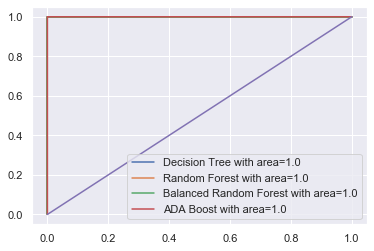

In [141]:
model_roc6pca=roc_auc_score(y_test, y_pred6pca)
fpr6pca,tpr6pca,thresholds6pca=roc_curve(y_test, model6pca.predict_proba(X_test_pca)[:,1])

model_roc7pca=roc_auc_score(y_test, y_pred7pca)
fpr7pca,tpr7pca,thresholds7pca=roc_curve(y_test, model7pca.predict_proba(X_test_pca)[:,1])

model_roc8pca=roc_auc_score(y_test, y_pred8pca)
fpr8pca,tpr8pca,thresholds8pca=roc_curve(y_test, model8pca.predict_proba(X_test_pca)[:,1])

model_roc9pca=roc_auc_score(y_test, y_pred9pca)
fpr9pca,tpr9pca,thresholds9pca=roc_curve(y_test, model9pca.predict_proba(X_test_pca)[:,1])

plt.figure()

plt.plot(fpr6pca,tpr6pca, label=f'Decision Tree with area={model_roc6pca.round(2)}')
plt.plot(fpr7pca,tpr7pca, label=f'Random Forest with area={model_roc7pca.round(2)}')
plt.plot(fpr8pca,tpr8pca, label=f'Balanced Random Forest with area={model_roc8pca.round(2)}')
plt.plot(fpr9pca,tpr9pca, label=f'ADA Boost with area={model_roc9pca.round(2)}')

plt.plot([0,1],[0,1])
plt.legend()
plt.show()

## Test

Wrap up:
1. cleaned train df
2. vectorized it
3. clustered it
4. got dummies, whatsoever
5. built models and fit them.

What to do with test dataset?
1. use the same functions/procedures to clean test dataset
2. apply the trained vectorizer to test dataset
3. apply clusters to test dataset
4. use the same following transformations after
5. test your model on test dataset.

### FEATURES IMPORTANCE

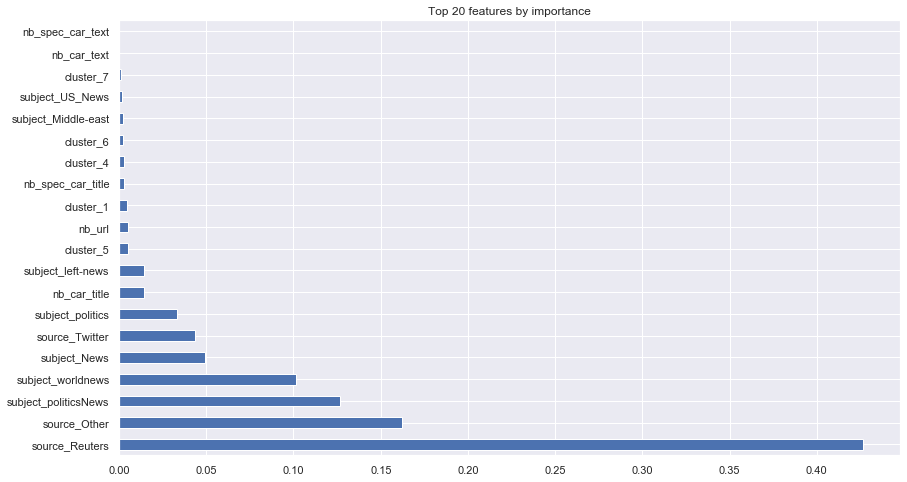

In [154]:
from sklearn.ensemble import ExtraTreesClassifier


X=X_train.drop(['T/F'], axis=1)
y=X_train['T/F']

model = ExtraTreesClassifier()
model.fit(X,y)

plt.figure(figsize=(14,8))
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.title('Top 20 features by importance')
plt.show()

In [203]:

import timeit
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore")




def numericalCategoricalSplit(df):
    numerical_features=df.select_dtypes(exclude=['object']).columns
    categorical_features=df.select_dtypes(include=['object']).columns
    numerical_data=df[numerical_features]
    categorical_data=df[categorical_features]
    return(numerical_data,categorical_data)



def nullFind(df):
    null_numerical=pd.isnull(df).sum().sort_values(ascending=False)
    #null_numerical=null_numerical[null_numerical>=0]
    null_categorical=pd.isnull(df).sum().sort_values(ascending=False)
   # null_categorical=null_categorical[null_categorical>=0]
    return(null_numerical,null_categorical)



def removeNullRows(df,few_null_col_list):
    for col in few_null_col_list:
        df=df[df[col].notnull()]
    return(df)
    
 


def EDA(df,labels,target_variable_name,
        data_summary_figsize=(16,16),corr_matrix_figsize=(16,16),
        data_summary_figcol="Reds_r",corr_matrix_figcol='Blues',
        corr_matrix_annot=False,
        pairplt_col='all',pairplt=False,
        feature_division_figsize=(12,12)):
    
    start_time = timeit.default_timer()
    
    #for converting class labels into integer values
    if df[target_variable_name].dtype=='object':
        class_labels=df[target_variable_name].unique().tolist()
        class_labels=[x for x in class_labels if type(x)==str]
        class_labels=[x for x in class_labels if str(x) != 'nan']
      
        for i in range(len(class_labels)):
            df[target_variable_name][df[target_variable_name]==class_labels[i]]=i
            
            
    df_orig=df
    print('The data looks like this: \n',df_orig.head())
    print('\nThe shape of data is: ',df_orig.shape)
    
    #To check missing values
    print('\nThe missing values in data are: \n',pd.isnull(df_orig).sum().sort_values(ascending=False))
    sns.heatmap(pd.isnull(df_orig))
    plt.title("Missing Values Summary", fontsize=(15), color="red")
    
    
   

    print('\nThe summary of data is: \n',df_orig.describe())
    plt.figure(figsize=data_summary_figsize)
    sns.heatmap(df_orig.describe()[1:].transpose(), annot= True, fmt=".1f",
                linecolor="black", linewidths=0.3,cmap=data_summary_figcol)
    plt.title("Data Summary", fontsize=(15), color="red")
    
      
   

    
    print('\nSome useful data information: \n')
    print(df_orig.info())
    print('\nThe columns in data are: \n',df_orig.columns.values)
    
    
    
   
    null_cutoff=0.5

    numerical=numericalCategoricalSplit(df_orig)[0]
    categorical=numericalCategoricalSplit(df_orig)[1]
    null_numerical=nullFind(numerical)[0]
    null_categorical=nullFind(categorical)[1]
    null=pd.concat([null_numerical,null_categorical])
    null_df=pd.DataFrame({'Null_in_Data':null}).sort_values(by=['Null_in_Data'],ascending=False)
    null_df_many=(null_df.loc[(null_df.Null_in_Data>null_cutoff*len(df_orig))])
    null_df_few=(null_df.loc[(null_df.Null_in_Data!=0)&(null_df.Null_in_Data<null_cutoff*len(df_orig))])

    many_null_col_list=null_df_many.index
    few_null_col_list=null_df_few.index
    
    #remove many null columns
    df_orig.drop(many_null_col_list,axis=1,inplace=True)
    
    df_wo_null=(removeNullRows(df_orig,few_null_col_list))
    
    
    if df_wo_null[target_variable_name].dtype=='object':
        df_wo_null[target_variable_name] =df_wo_null[target_variable_name].astype(str).astype(int)
   
    
    df=df_wo_null[df_wo_null.select_dtypes(exclude=['object']).columns]
   
    
    #Check correlation matrix
    plt.figure(figsize=corr_matrix_figsize)
    sns.heatmap(df.corr(),cmap=corr_matrix_figcol,annot=corr_matrix_annot) 
    
    
    col = df.columns.values
    number_of_columns=len(col)
    number_of_rows = len(col)-1/number_of_columns
    
    
    #To check Outliers
    plt.figure(figsize=(number_of_columns,number_of_rows))
    
    for i in range(0,len(col)):
        #plt.subplot(number_of_rows + 1,number_of_columns,i+1)
        if number_of_columns%2==0:
            plt.subplot(number_of_columns/2,2,i+1)   
            sns.set_style('whitegrid')
            sns.boxplot(df[col[i]],color='green',orient='h')
            plt.tight_layout()
        else:
            plt.subplot((number_of_columns+1)/2,2,i+1)
            sns.set_style('whitegrid')
            sns.boxplot(df[col[i]],color='green',orient='h')
            plt.tight_layout()
    
    
    #To check distribution-Skewness
    for i in range(0,len(col)):
        fig,axis = plt.subplots(1, 2,figsize=(16, 5))
        sns.distplot(df_orig[col[i]],kde=True,ax=axis[0]) 
        axis[0].axvline(df_orig[col[i]].mean(),color = "k",linestyle="dashed",label="MEAN")
        axis[0].legend(loc="upper right")
        axis[0].set_title('distribution of {}. Skewness = {:.4f}'.format(col[i] ,df_orig[col[i]].skew()))
        
        sns.violinplot(x=target_variable_name, y=col[i], data=df_orig, ax=axis[1], inner='quartile')
        axis[1].set_title('violin of {}, split by target'.format(col[i]))
    
       
    
    #to construct pairplot
    if (pairplt==True) and (pairplt_col!='all'):
        sns.pairplot(data=df, vars=pairplt_col, hue=target_variable_name)
    elif (pairplt==True) and (pairplt_col=='all'):
        sns.pairplot(data=df, vars=df.columns.values, hue=target_variable_name)
   
    
    
    #Proportion of target variable in dataset   
    
    st=df[target_variable_name].value_counts().sort_index()
    print('\nThe target variable is divided into: \n',st) #how many belong to each class of target variable
    
    
    
    plt.figure(figsize=feature_division_figsize)
    plt.subplot(121)
    ax = sns.countplot(y = df_orig[target_variable_name],
                     
                       linewidth=1,
                       edgecolor="k"*2)
    for i,j in enumerate(st):
        ax.text(.7,i,j,weight = "bold",fontsize = 27)
    plt.title("Count for target variable in datset")
    
    
    plt.subplot(122)
    plt.pie(st,
            labels=labels,
            autopct="%.2f%%",wedgeprops={"linewidth":2,"edgecolor":"white"})
    my_circ = plt.Circle((0,0),.7,color = "white")
    plt.gca().add_artist(my_circ)
    plt.subplots_adjust(wspace = .2)
    plt.title("Proportion of target variable in dataset")
    
    
    print('\nThe numerical features are: \n',df_wo_null.select_dtypes(exclude=['object']).columns.tolist())
    print('\nThe categorical features are: \n',df_wo_null.select_dtypes(include=['object']).columns.tolist())
    
    #Proportion of categorical variables in dataset   
    if len(df_wo_null.select_dtypes(include=['object']).columns.tolist())>=1:
        for cat_feat in df_wo_null.select_dtypes(include=['object']).columns.tolist():
            
            ct=df_wo_null.select_dtypes(include=['object'])[cat_feat].value_counts().sort_values(ascending=False)
            print('\nThe categorical variable is divided into: \n',ct) #how many belong to each class of target variable
            
            
            if (ct.index.size)<50:
                plt.figure(figsize=feature_division_figsize)
                plt.subplot(121)
                ax = sns.countplot(y = df_wo_null.select_dtypes(include=['object'])[cat_feat],
                                  
                                   linewidth=1,
                                   edgecolor="k"*2)
                for i,j in enumerate(ct):
                    ax.text(.7,i,j,weight = "bold",fontsize = 27)
                plt.title("Count for categorical variable in datset")
                
                
                plt.subplot(122)
                plt.pie(ct,
                        labels=df_wo_null.select_dtypes(include=['object'])[cat_feat].unique().tolist(),
                        autopct="%.2f%%",wedgeprops={"linewidth":2,"edgecolor":"white"})
                my_circ = plt.Circle((0,0),.7,color = "white")
                plt.gca().add_artist(my_circ)
                plt.subplots_adjust(wspace = .2)
                plt.title("Proportion of categorical variable in dataset")
            else:
                print('\nThe categorical variable %s has too many divisions to plot \n'%cat_feat)
            continue
    elapsed = timeit.default_timer() - start_time
    print('\nExecution Time for EDA: %.2f minutes'%(elapsed/60))
    
    
    return df_wo_null,df_wo_null.select_dtypes(exclude=['object']).columns.tolist(),df_wo_null.select_dtypes(include=['object']).columns.tolist()

In [205]:
EDA(X_train, X_train, X_train)

ValueError: Boolean array expected for the condition, not int64

The data looks like this: 
        T/F  nb_car_title  nb_car_text  is_image  nb_spec_car_text  \
43640    0            64         1882         0                33   
11791    1            75         2675         0                73   
9702     1            53         2182         0                56   
23323    0            91         2558         1                59   
13032    1            82          739         0                11   

       nb_spec_car_title  nb_url  subject_Middle-east  subject_News  \
43640                  4       0                    0             0   
11791                  1       0                    0             0   
9702                   2       0                    0             0   
23323                  1       0                    0             1   
13032                  1       0                    0             0   

       subject_US_News  ...  cluster_1  cluster_2  cluster_3  cluster_4  \
43640                1  ...          0          0      

RuntimeError: Selected KDE bandwidth is 0. Cannot estiamte density.

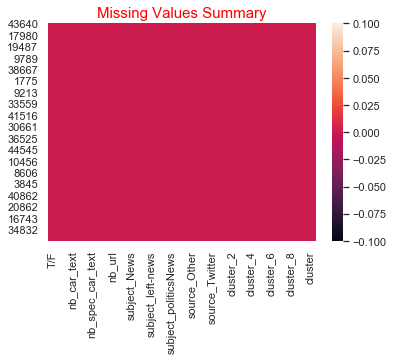

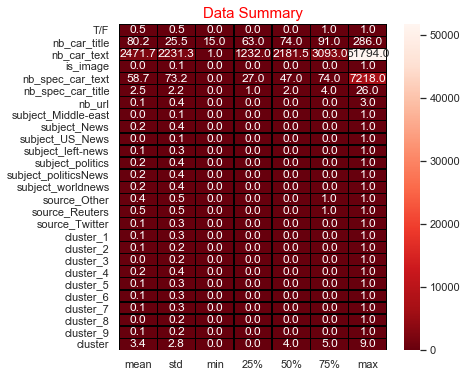

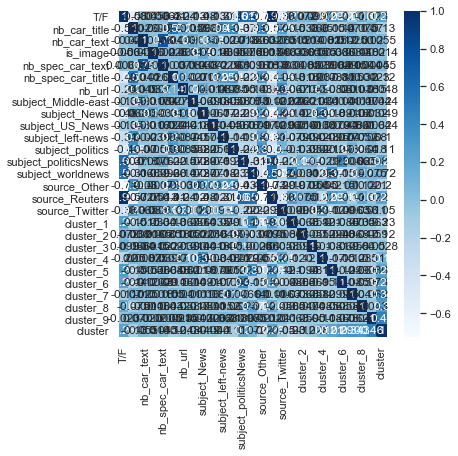

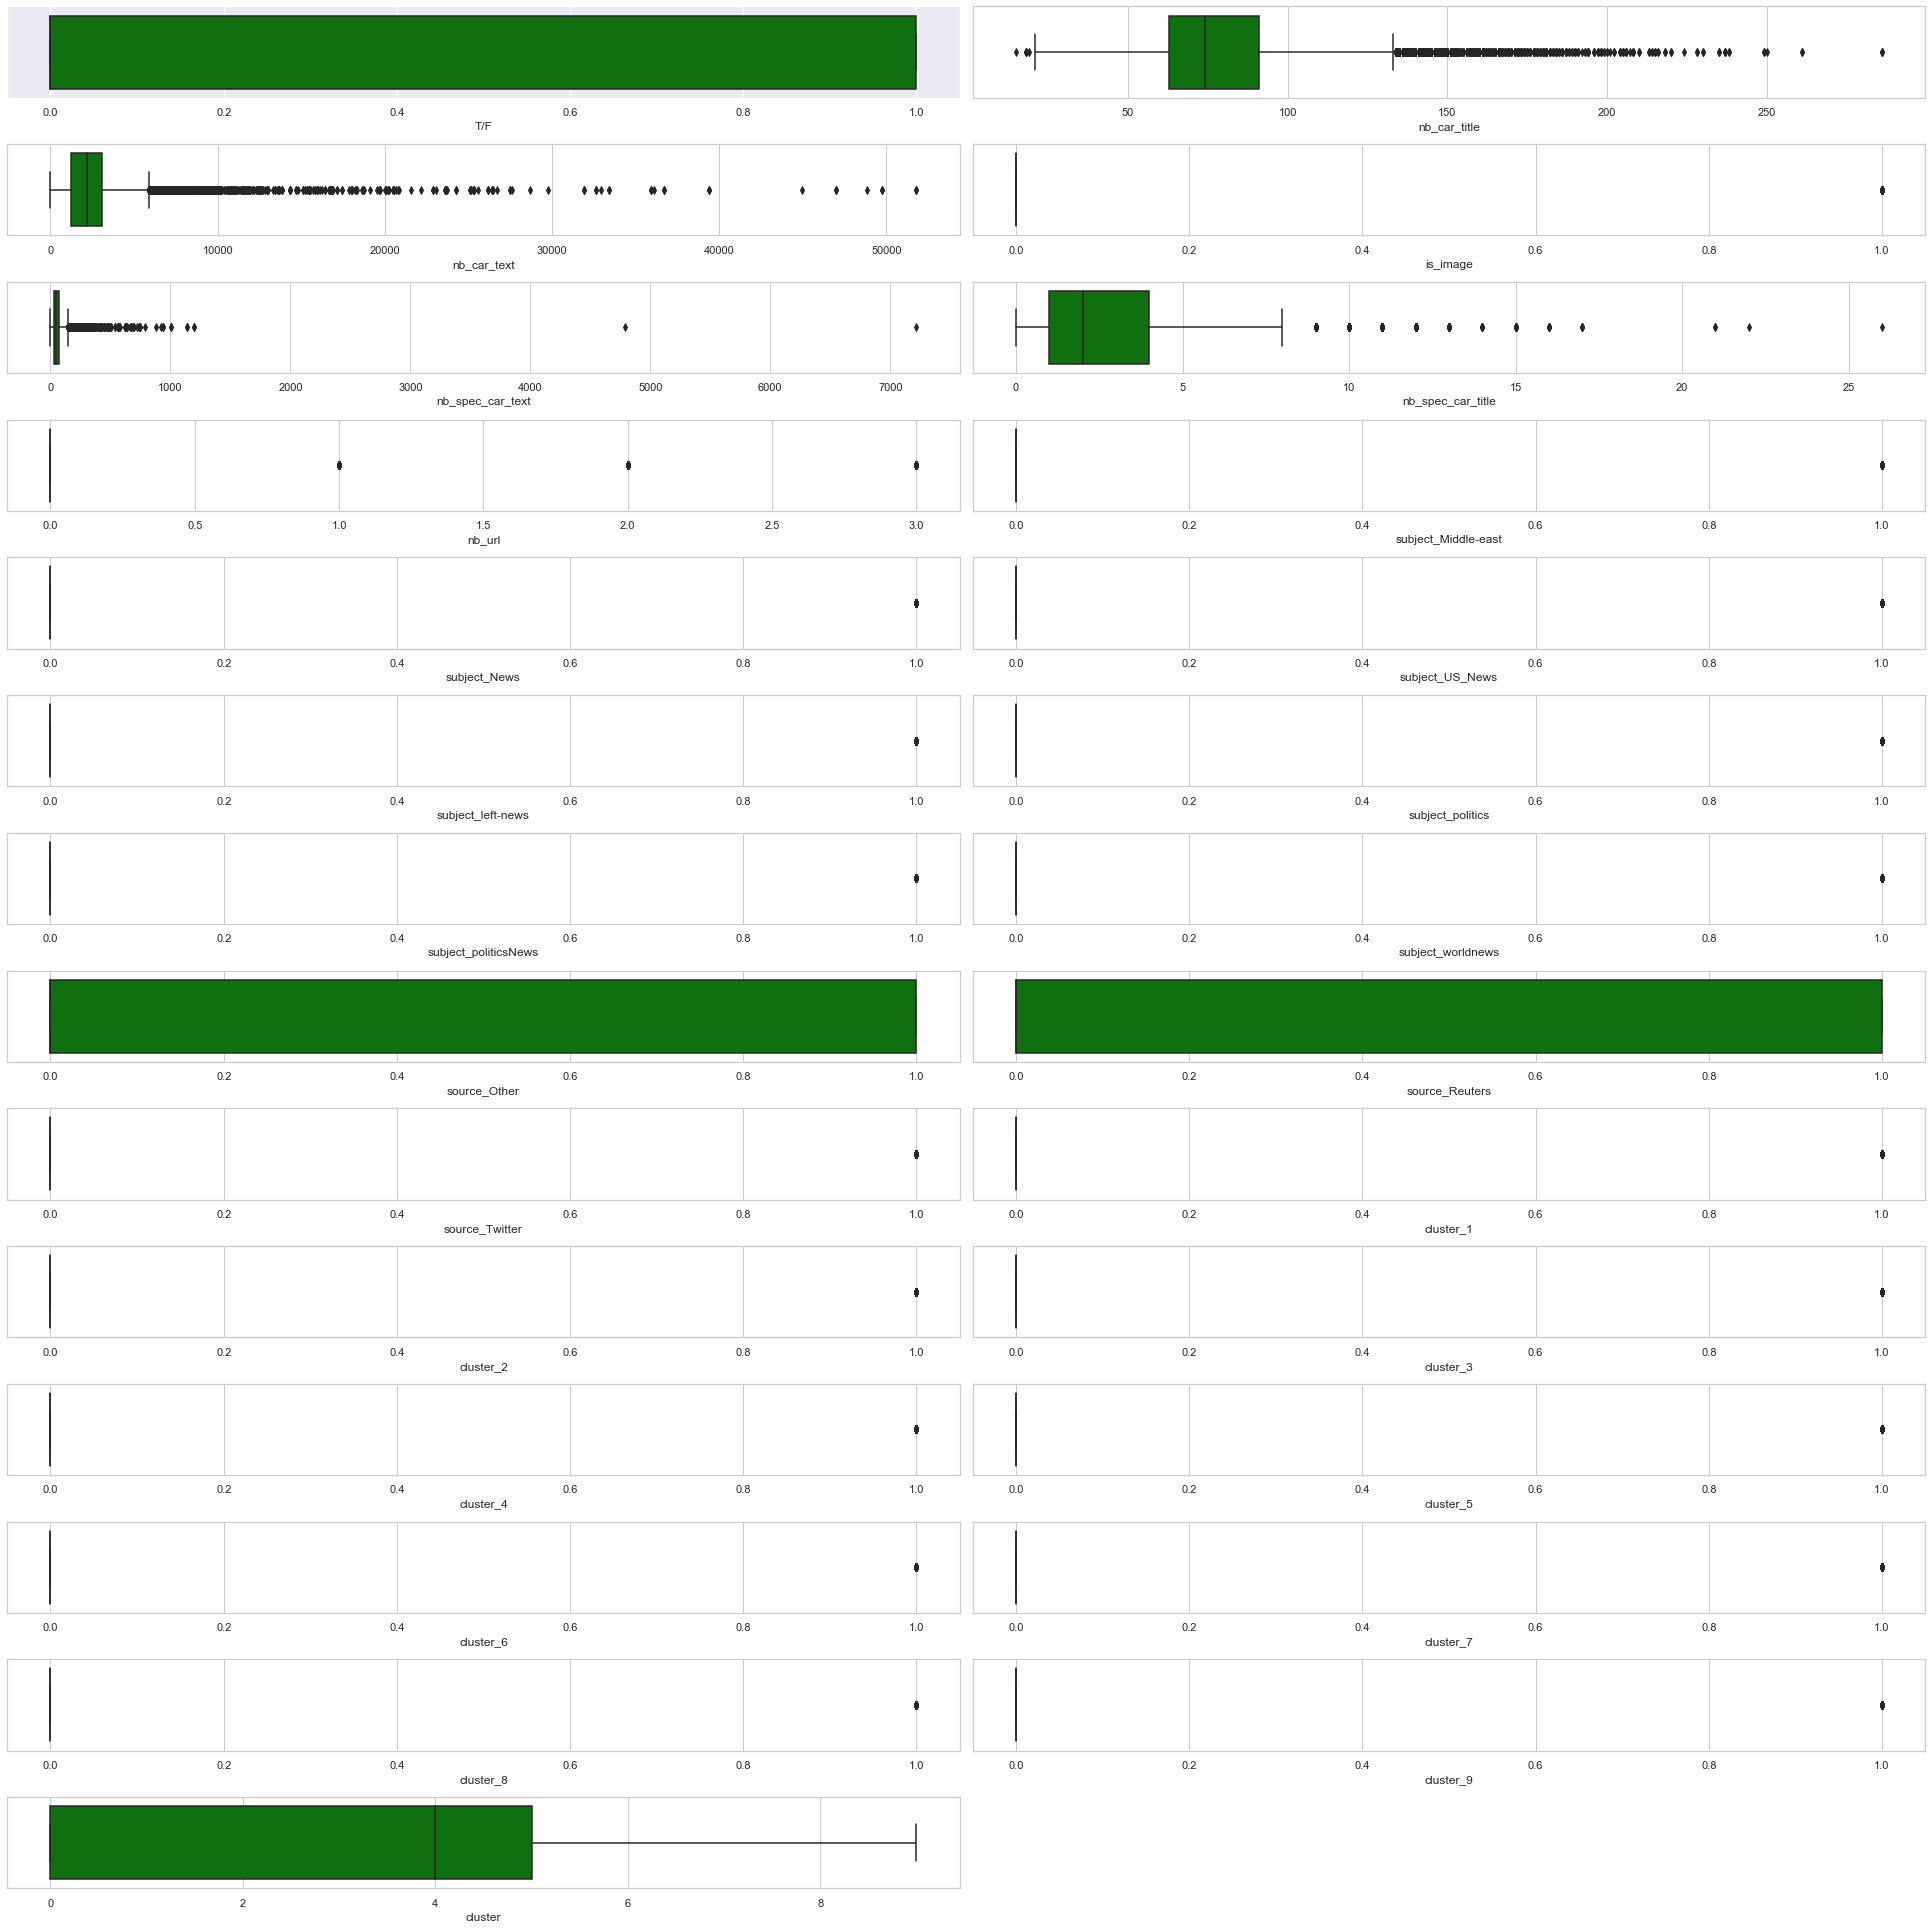

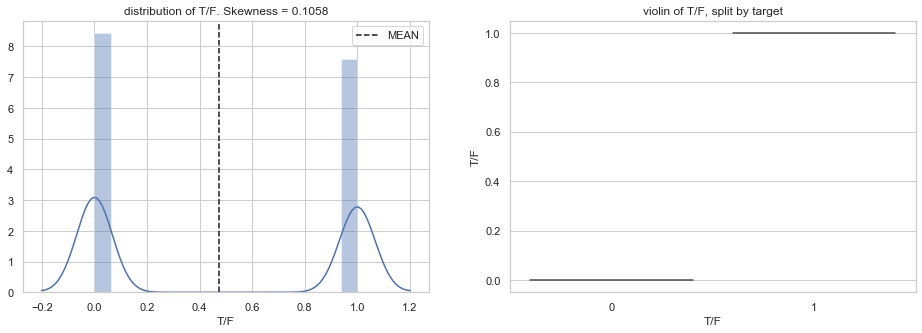

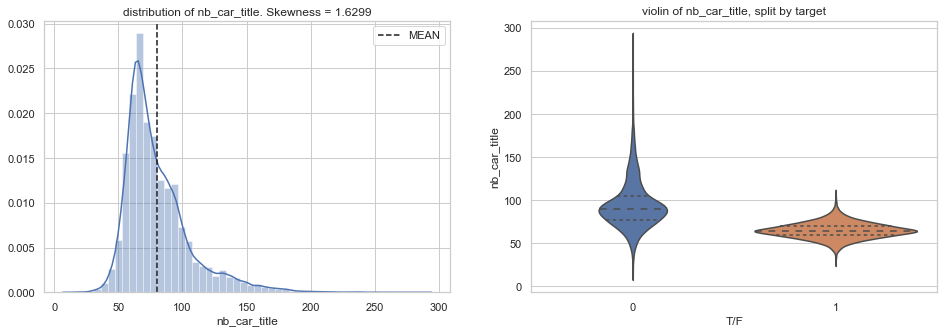

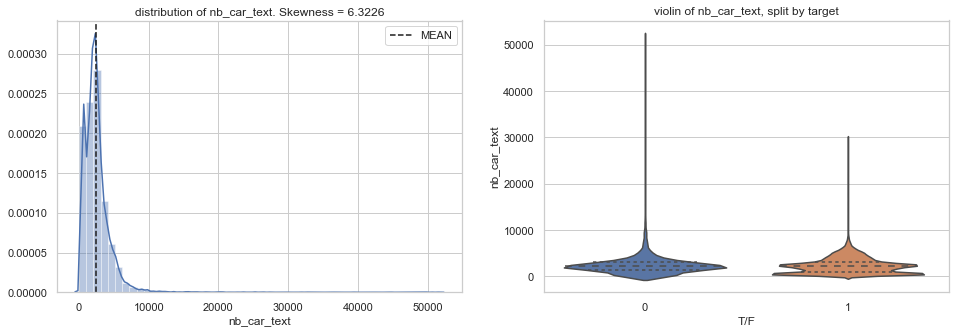

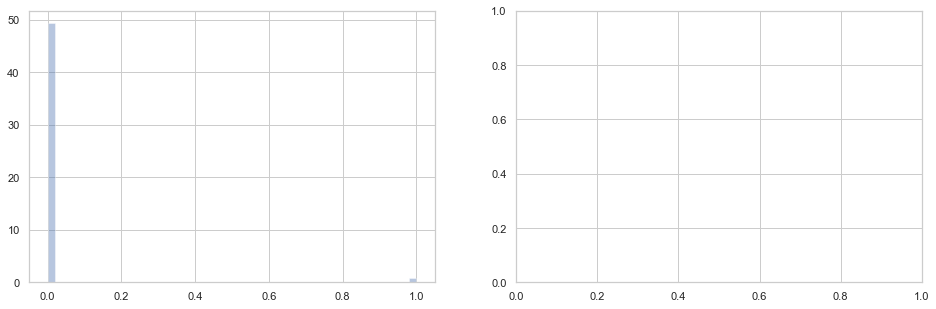

In [206]:
df=X_train
target_variable_name='T/F'
labels=[X_train.columns]
df_processed,num_features,cat_features=EDA(df,labels,
                                         target_variable_name,
                                         data_summary_figsize=(6,6),
                                         corr_matrix_figsize=(6,6),
                                         corr_matrix_annot=True,
                                         pairplt=True)